## Before you dip into this file
This notebook shows all inputs needed for the calculation of the EBL,
and how to calculate the outputs.

There is another file included in the package, 'ebl_from_input_file.py', which plots all the figures we present here given a specific input file. This notebook introduces the inputs of the package in a general way, but once you understand how it works it is more useful to use the other one to check how the inputs and results are for a specific input configuration.

# Imports

In [1]:
# Check that the working directory is correct for the paths
import os

if os.path.basename(os.getcwd()) == 'scripts' or os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir("..")

# If the directory for outputs is not present, create it.
if not os.path.exists("outputs/"):
    os.makedirs("outputs/")

In [2]:
import yaml
#import psutil
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
import astropy.constants as c
from scipy.integrate import simpson
from scipy.interpolate import UnivariateSpline, RegularGridInterpolator

#from niebla import ebl_model, measurements
from src.niebla import ebl_model
import src.niebla.measurements as measurements


# If we want to compare our results to previous calculations of the EBL, we load ebltable
# from https://github.com/me-manu/ebltable
from ebltable.ebl_from_model import EBL

Module hmf not loaded


### Some matplotlib values that I like for my graphs
Please feel free to change these (but I think they are cool)

In [3]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.labelsize'] = 20
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=17)
plt.rc('xtick', top=True, direction='in')
plt.rc('ytick', right=True, direction='in')
plt.rc('xtick.major', size=7, width=1.5, top=True)
plt.rc('ytick.major', size=7, width=1.5, right=True)
plt.rc('xtick.minor', size=4, width=1)
plt.rc('ytick.minor', size=4, width=1)

In [4]:
# Some arrays to distinguish different models in the next plots
models = ['solid', 'dashed', 'dotted', 'dashdot']
colors = ['b', 'r', 'g', 'orange', 'grey', 'purple', 'k', 'cyan', 'brown']

linstyles_ssp = ['solid', '--', 'dotted', '-.']

markers = ['.', 'x', '+', '*', '^', '>', '<']
color_ssp = ['b', 'orange', 'k', 'r', 'green', 'grey', 'limegreen', 'purple', 'brown']

# Configuration file reading and data input/output

In [5]:
# Directory where we have the yaml file that has the inputs for our model
# If you want to save figures, it's very useful to use this directory to save them
# (i.e. plt.savefig(input_file_dir + NAME_FIG.pdf, bbox_inches='tight'))

input_file_dir = ('notebooks/')

In [6]:
# Configuration file reading and data input/output
def read_config_file(ConfigFile):
    with open(ConfigFile, 'r') as stream:
        try:
            parsed_yaml = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return parsed_yaml

# We initialize the class with the input file
config_data = read_config_file(input_file_dir + 'input_example.yml')
ebl_class = ebl_model.EBL_model.input_yaml_data_into_class(config_data, log_prints=True)

2025-09-01 18:09:12 - INFO - 0.02s: Initialize class: end


### Details about config files
There is a problem that sometimes happens when inputting strings from yaml files. Sometimes the reader assumes that each character is to be read individually instead of as a string all together. If you ask for the length of the input, it counts each letter. Then, a parameter with the name `param_1: helloWorld` might recognize this as an array of individual characters, and asking
```
dict = {'param_1': helloWorld}
print(len(dict['param_1']))
 > 10 
```
The solution to this issue is to properly use [' '] in the config file sorrounding the string. That will cause python to always read it correctly. This almost never happens but when it does is kind of a nightmare. So beware.

## Inputs in the config file
List of inputs in the config file and its definitions.

First, general ones that need to appear for the correct funtioning of the code:

**COSMOLOGY CONSTANTS (flat LCDM assumed)**
```
cosmology_params:
  cosmo: [0.7, 0.3, 0.7] # [h_0, omega_matter, omega_L]
  omegaBar: 0.0453 # omega baryons of our model (this example = 0.0222/0.7**2.)
```
> These four parameters $h_0$, $\omega_{matter}$, $\omega_{\lambda}$ and $\omega_{baryons}$ are input in the class `FlatLambdaCDM` of `astropy.cosmology`. They can be changed, but beware because if you want to compare them to data: in order to calculate data, a cosmological model is assumed (for most observations). Altering the cosmological model might make it impossible (or wrong) to compare the output model with observational data.

**WAVELENGTH ARRAY FOR EBL [microns]**
```
wavelength_array:
  wv_min: 1e-2
  wv_max: 1e5
  wv_steps: 700
```
> Wavelength array where to calculate the EBL intensities and emissivities. They have to be given in microns. This example covers both the optical and infrared parts of the electromagnetic spectrum.

**REDSHIFT ARRAY FOR EBL**
```
redshift_array:
  z_min: 0.
  z_max: 10.
  z_steps: 100
```
> This is the redshift array where the emissivities and EBL will be avaible as outputs. This does not denote the integration limit at high redshift. That one is given by the next parameter:
```
z_intmax: 40.0
```
> This is $z_{max}$ in Eq.(B1) in the paper based on this code, its physical meaning is the maximum reshift ar which the . I reccomend to not change this value.

**NUMBER OF INTEGRATION STEPS**
```
t_intsteps: 201
```
> Same as before, this number is appropiate for sampling the integral kernels.

**PRINT THE LOGS OF THE PROGRAM**

```
log_prints: True
```
> Finally, the possibility of having the program spit all the verbose or silently run. Change this parameter at any point in your program to decide whether you want detailed information about the processes happening or you would prefer the calculations to be silent.

# Stellar contribution to the EBL
We call it stellar, but in reality any contribution with tabulated luminosities can be input for the package to calculate its emissivity and EBL intensity.
Moreover, we could also input here emissivity values and use a constant formation rate to calculate EBL intensities. That works as long as the units are correctly input. More info about this in the ebl_outputs.ipynb.

We provide various examples if stellar contributions in the input_example.yaml file.

For and example of an SSP config file, we can have:
```
Example_SB99_Chary:

  dust_abs_models:
    - finke2022
  dust_abs_params:
    fesc_steps_fn22:
      - 0.19026841739819628
      - 0.21769647479187074
      - 0.24664564616751203
      - 0.4405596977469474
      - 0.702267829157408
    params_fermi18:
      - 1.52
      - 0.35
      - 4.12
      - 5.89
      
  dust_reem: true
  dust_reem_parametrization:
    library: dust_reem_chary2001
    f_tir: 9.68  # [dex]
    wv_reem_min: 5.33  # [microns]
    
  metall_formula: 'metall_tanikawa22'
  metall_params:
    - -1.363077660454558e-06
    - 0.1709136894779165
    - 1.0750514513578506
    - 0.02
    
  name: 'Example SB99 and Chary'
  
  sfr_formula: 'sfr_madau14'
  sfr_params:
    - 0.015915657766652082
    - 2.303543288627401
    - 3.287937285946092
    - 6.633075702961276
    
  ssp:
    ssp_type: 'example_SB99'
```
We now describe each of these inputs in the next cells, explaining all the parametrizations that appear in this config example.

## SSP synthetic spectra - input for stellar EBL contribution
A simple stellar population (SSP) is defined as a group of stars born from the same gas cloud, which then evolve with no further star formation. The birth of the SSP lasts for megayears, so for cosmological purposes it can be assumed to be instantaneous. The stars in an SSP are assumed to share the same metallicity and age.

For this EBL calculation we input synthetic stellar spectra from SSPs. The spectra have to depend on wavelength, age of the population and (optionally) metallicity.

The way of inputting the stellar spectra is with our trustworthy config file. There are two available types of files accepted to input the populations. They are based on the filesystem of some scripts of synthetic spectra creation outputs. They are:
- Starburst99 (SB99) - simulations performed with the [Starburst99 code](https://massivestars.stsci.edu/starburst99/docs/default.htm).
- Generic (generic) - any kind of spectra, as long as they are correctly formatted (how to, explained below).

The parameters that can be present in the input file are, for each of the types:
```
ssp_SB99:
    ssp_type: SB99
    path_ssp: data/ssp_synthetic_spectra/starburst99/...
    file_name: /kroupa_
    ignore_rows: 6
    total_stellar_mass: 6  # (dex)
    L_lambda: True

ssp_generic:
    ssp_type: generic
    path_ssp: data/ssp_synthetic_spectra/...
    ignore_rows: 6
    total_stellar_mass: 6  # (dex)
    L_lambda: True
```

The input file needs the total initial mass of the population, to calculate the normalization factor. The default value for SB99 simulations is $10^6 M_{\odot}$, so ```total_stellar_mass: 6 (dex)```.

The parameter `ignore_rows: 6` allows to control whether the numerical data start in the first row of the file, or it would be necessary to jump some when reading in the file. In SB99 the typical jumping point are 6 rows, but generally if the files contain no other information this parameter can be set to 0.

Since it is possible to input $L_{\lambda}$ or $L_{\nu}$, we have the parameter `L_lambda: True`, which is expected to be `True` with $L_{\lambda}$ and `False` with $L_{\nu}$ datasets. The relation between these two is $\lambda L_{\lambda} = \nu L_{\nu}$.

Depending on `ssp_type` different parameters are needed. Inputs from SB99 need an extra parameter, the ```file_name```. If you have the outputs from a SB99 simulation, you can see that each file includes the name of the IMF used and the metallicity. We only use the metallicity information, so we need to separate the useful part of the file name.


The filesystem of the `generic` type has to be precise in order to be correctly read and used. We want a directory, linked by `path_ssp`. In this directory we expect to find a number of files (one or more), each file name being the SSP metallicity of the data inside the file. The data format in each file is specific:
- The [0,0] entry is empty.
- The zeroth column [1:, 0] contains the wavelengths [Angstroms].
- The first row [0, 1:] contains the time/age of the SSP [years].
- The remaining values (n x m) are the luminosity $L_{\lambda}$ [erg/sec/A/Msun] or $L_{\nu}$ [erg/sec/Hz/Msun].
            
This method assumes that all files share the wavelength and age array. We provide an example of a minimal directory and ssp luminosity file in ```minimal-example/ssp_minimal```.

A possible script to transform your data into a readable format by the code is:
```
import os
import numpy as np

input_dir = 'data/ssp_synthetic_spectra/pegase3/spectra_Kroupa/'

# A directory to store our spectra
output_dir = 'data/ssp_synthetic_spectra/pegase3/spectra_Kroupa_newformat/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# We list all the files that we want to transform into the readable format
# (depending on the spectral library, other kind of loading might need to take place)
file_name = os.listdir(input_dir)
print(file_name)

for ind_file in file_name:
    data = np.loadtxt(input_dir + ind_file)

    # We want to name the new files with only the metallicity of each file,
    # this naming system will allow to read the filesystem automatically but
    # it needs a specific naming convention
    metall_string = ind_file.replace('.txt', '')
    metall_string = metall_string.replace('spectral_resultsZ', '')
    print(metall_string)

    # The name of each new file has to be only the metallicity of the stellar population
    file_out = open(output_dir + metall_string, 'w')

    wavelength_array = AAAAA  # WAVELENGTH ARRAY, HAS TO BE GIVEN IN AMSTRONGS
    ages_array = AAAAA  # AGE ARRAY, HAS TO BE GIVEN IN YEARS

    len_wv = np.shape(wavelength_array)[0]
    len_age = np.shape(ages_array)[0]

    data_arr = np.zeros((len_wv + 1, len_age + 1))
    data_arr[1:, 0] = wavelength_array
    data_arr[0, 1:] = ages_array
    data_arr[1:, 1:] = AAAAA  # 2D ARRAY WITH LUMINOSITIES L_lambda, in units erg/s/Amstrong/M_sun

    np.savetxt(file_out, data_arr)
    file_out.close()
```



SSP model:  Stripped Goetberg19


2025-09-01 18:09:12 - INFO - 0.70s: Reading of SSP file



SSP model:  Example SB99 and Chary


2025-09-01 18:09:14 - INFO - 1.24s: Reading of SSP file



SSP model:  Example SB99 with Bosa


2025-09-01 18:09:15 - INFO - 1.38s: Reading of SSP file
2025-09-01 18:09:15 - INFO - 0.01s: Reading of SSP file



SSP model:  Custom example


Text(0, 0.5, 'log$_{10}$(L$_{\\lambda}$ [erg s$^{-1}$ $\\mathrm{\\AA}^{-1}$ M$_{\\odot}^{-1}$])')

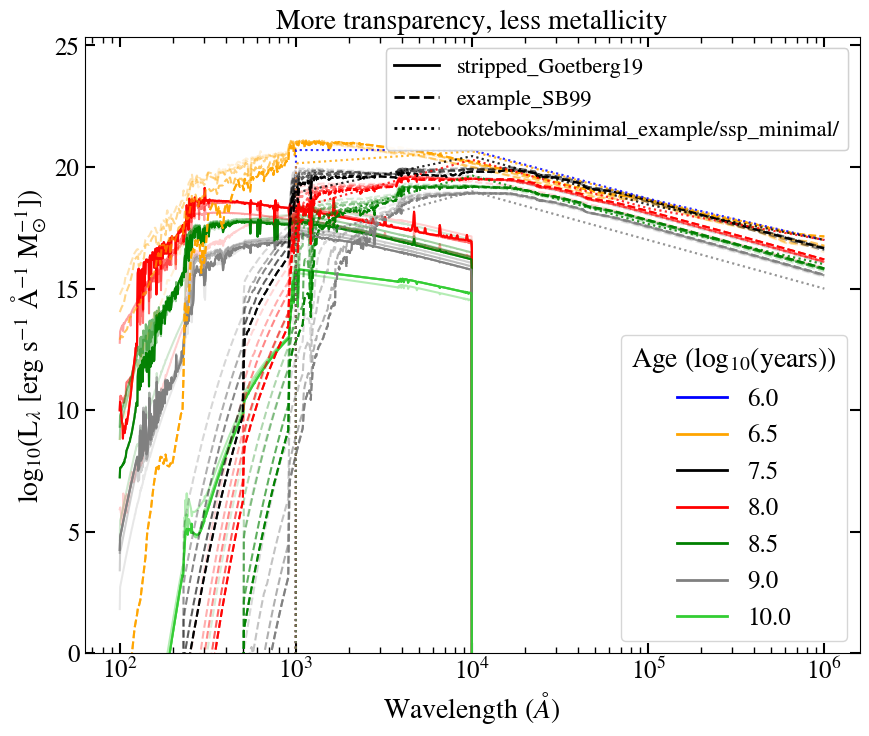

In [7]:
fig_ssp, ax_ssp = plt.subplots(figsize=(10, 8))

xx_amstrongs = np.logspace(2, 6, 2000)

previous_ssp = []
labels_ssp1 = []
handles_ssp1 = []
labels_ssp2 = []
handles_ssp2 = []

# Plot the synthetic spectra populations
for nkey, key in enumerate(config_data['ssp_models']):
    print()
    print('SSP model: ', config_data['ssp_models'][key]['name'])

    ssp_yaml = config_data['ssp_models'][key]['ssp']

    ebl_class.read_SSP_file(ssp_yaml)

    if ('path_ssp' not in config_data['ssp_models'][key]['ssp']
        or
        config_data['ssp_models'][key]['ssp']['path_ssp']
        not in previous_ssp):
        # Check so the examples are only plotted once
        if (config_data['ssp_models'][key]['ssp']['ssp_type']
                in previous_ssp):
            continue
        try:
            previous_ssp.append(
                config_data['ssp_models'][key]['ssp']['path_ssp'])
            labels_ssp2.append(
                config_data['ssp_models'][key]['ssp']['path_ssp'])
        except KeyError:
            previous_ssp.append(
                config_data['ssp_models'][key]['ssp']['ssp_type'])
            labels_ssp2.append(
                config_data['ssp_models'][key]['ssp']['ssp_type'])

        handles_ssp2.append(
            plt.Line2D([], [], linewidth=2,
                       linestyle=linstyles_ssp[len(previous_ssp) - 1],
                       color='k'))

        list_met = np.sort(ebl_class._ssp_metall)

        for n_met, met in enumerate(list_met):
            for i, age in enumerate([6.0, 6.5, 7.5, 8., 8.5, 9., 10.]):
                ax_ssp.plot(
                    xx_amstrongs,
                    ebl_class.ssp_lumin_spline(
                        wv_array=xx_amstrongs, age_array=age,
                        metall_array=np.log10(met)),
                    linestyle=linstyles_ssp[len(previous_ssp) - 1],
                    color=color_ssp[i],
                    alpha=float(n_met) / len(list_met) * 1.1
                )
                if n_met == 0 and len(previous_ssp) == 1:
                    labels_ssp1.append(age)
                    handles_ssp1.append(
                        plt.Line2D([], [], linewidth=2, linestyle='-',
                                   color=color_ssp[i]))

legend11 = plt.legend(handles_ssp1, labels_ssp1,
                      loc=4,
                      title=r'Age (log$_{10}$(years))')
legend22 = plt.legend(handles_ssp2, labels_ssp2,
                      loc=1, fontsize=16
                      )
ax_ssp.add_artist(legend11)
ax_ssp.add_artist(legend22)

plt.xscale('log')

plt.title('More transparency, less metallicity')

plt.ylim(bottom=0)

plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'log$_{10}$(L$_{\lambda}$ '  # /Lsun '
           r'[erg s$^{-1}$ $\mathrm{\AA}^{-1}$ M$_{\odot}^{-1}$])')

## Dust absorption models
We provide some analytical models of dust absorption. Some of them give a wavelength dependence, other redshift one. Usually, they are combined into single model. The list of available dependencies is:

| Wavelength dependence | Name in the code | Link |
| :-:  | :-:  | :-:  |
|$f_\mathrm{esc, dust}(\lambda) = 10^{-0.4\,A_{\lambda}}$ with $A_{\lambda} = 0.68 \cdot E(B-V) \cdot R \cdot (\lambda^{-1}-0.35)$ | kneiske2002 | [Eq. 6](https://www.aanda.org/articles/aa/abs/2002/16/aa1647/aa1647.html) |
| *it has many lines, check the paper* | razzaque2009 | [Eq. 15](https://iopscience.iop.org/article/10.1088/0004-637X/697/1/483) |
| *it has many lines, check the paper* | dust_att_finke | [Eq. 13](https://iopscience.iop.org/article/10.3847/1538-4357/ac9843) |


| Redshift dependence | Name in the code | Link |
| :-: | :-: | :-: |
| $f_\mathrm{esc, dust}(z) = 10^{-0.4\,A_{z}}$ with $A(z) = m_d \frac{(1 + z)^{n_d}}{1 + [(1+z)/p_d]^{q_d}}$ | fermi2018 | [Paper](https://www.science.org/doi/10.1126/science.aat8123) |


We also provide two combined cases:

| Name in the code | Wavelength dependence | Redshift dependence |
| :-: | :-: | :-: |
| comb_model_1 | razzaque2009 | fermi2018 |
| finke2022 | dust_att_finke | fermi2018 |


The dependency is introduced with the input file, as before. The parameters are:
```
dust_abs_models: ['finke2022']
    dust_abs_params:
        params_fermi18: [ 1.52, 0.35, 4.12, 5.89]
        fesc_steps_fn22: [0.188, 0.218, 0.293, 0.393, 0.857]
```

The first parameter `dust_abs_models` can be either a string or an array of strings, definining which models will be used for each part of the wavelegth and redshift dust absorption models. If no model is recognized the code will tell.

The parameters of each model can be separately chosen. The code tries to input the parameters for each model from the input file. If it cannot find them, the default parameters will be used and printed on the command line.
If given, the parameters have to follow the conventions:
| Model name | Parameter array name | Parameter order | Default parameters |
| :-: | :-: | :-: | :-: |
| kneiske2002 | params_kneiske2002 |[ $E(B-V)$, $R$ ] | [0.15, 3.2] |
| razzaque2009 | lambda_cuts_rz09 | *check the paper* | [0.165, 0.220, 0.422] |
| razzaque2009 | initial_value_rz09 | *check the paper*  | [0.688, 0.151, 1.0, 0.728] |
| razzaque2009 | multipl_factor_rz09 | *check the paper*  | [0.556, -0.136, 1.148, 0.422] |
| dust_att_finke | lambda_steps_fn22 |$\lambda_i$, with $i=1,...,5$ | [0.15, 0.167, 0.218, 0.422, 2.] |
| dust_att_finke | fesc_steps_fn22 | $f_{\mathrm{esc, }i}$, with $i=1,...,5$ | [0.188, 0.218, 0.293, 0.393, 0.857] |
| fermi2018 | params_fermi18 |[ $m_d$, $n_d$, $p_d$, $q_d$ ] | [1.49, 0.64, 3.4, 3.54] |

The dust absorption can also be a custom input. In this case, you need a single callable or string that calculates the absorption both as a function of wavelenght and redshift. If you provide a string, the variables have to be called:

$wv$: wavelength array

$zz$: redshift array

$params$: dust parameters, which has to be an int, float or array

If you input a callable, the order of inputs has to be: wavelength, redshift, (params)
params is not necessary. For now, you need to give the custom fraction as log10.

I provide simple examples of the custom absorption in the next cell, and there is another example in ebl_outputs.ipynb.

   -> No dust absorption dependency with redshift.
   -> No dust absorption dependency with wavelength.
   -> No dust absorption dependency with wavelength.
Example of no dust abs chosen:
   -> No dust absorption model chosen.
      CAREFUL: has the model been correctly chosen?
      Number of model inputs in the array:  3


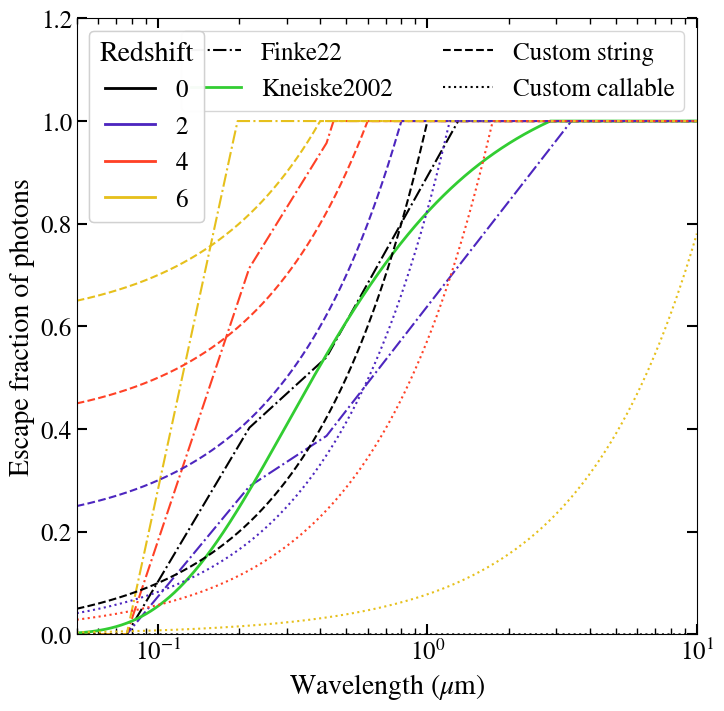

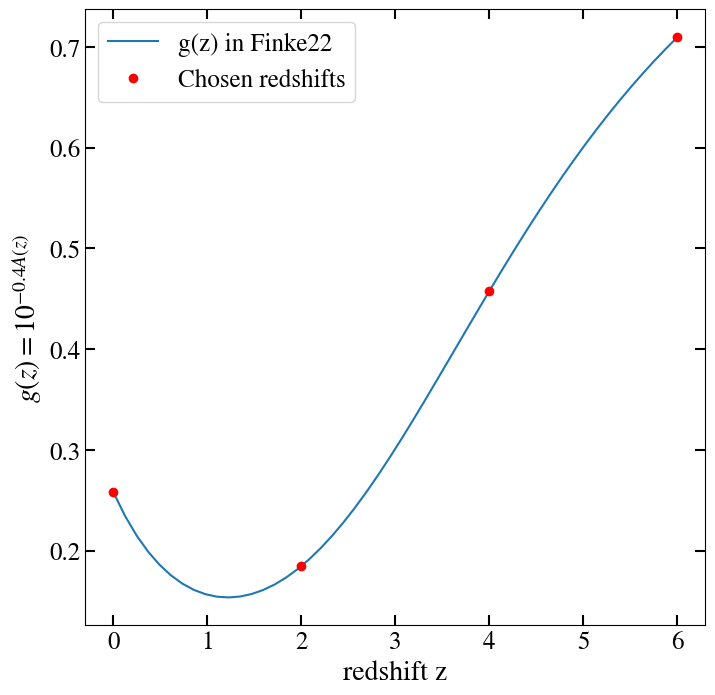

In [8]:
from src.niebla import ebl_model
import src.niebla.measurements as measurements

fig, ax0 = plt.subplots(figsize=(8, 8))

wv_dustabs = np.logspace(-2, 1, num=5000)
zz_dustabs = np.array([0, 2, 4, 6])
x_zetas = np.array([0, 2, 4, 6])
color_dustabs = []


for ni, ii in enumerate(zz_dustabs):
    
    color_dustabs.append(plt.cm.CMRmap(ni / float(len(zz_dustabs))))
    
    if ni == 0:
        plt.plot(wv_dustabs,
                 ebl_model.dust_abs_fraction(
                     wv_array=wv_dustabs,
                     z_array=zz_dustabs[ni],
                     models=['finke2022'],
                     verbose=False),
                 ls='-.', c=color_dustabs[ni],
                 label='Finke22')

    else:
        plt.plot(wv_dustabs,
                 ebl_model.dust_abs_fraction(
                     wv_array=wv_dustabs,
                     z_array=zz_dustabs[ni],
                     models=['finke2022'],
                     verbose=False),
                 ls='-.', c=color_dustabs[ni], label='')

plt.plot(wv_dustabs, ebl_model.dust_abs_fraction(
    wv_dustabs, models=['kneiske2002', '']),
         'limegreen',label='Kneiske2002', ls='-', lw=2)


# Custom string
custom_str = 'params[0] * zz + wv * params[1]'

for ni, ii in enumerate(zz_dustabs):

    color_dustabs.append(plt.cm.CMRmap(ni / float(len(zz_dustabs))))
    
    if ni == 0:
        plt.plot(wv_dustabs,
                 ebl_model.dust_abs_fraction(
                     wv_array=wv_dustabs,
                     z_array=zz_dustabs[ni],
                     models=custom_str,
                     dust_params=[0.1, 1.],
                     verbose=False),
                 ls='--', c=color_dustabs[ni],
                 label='Custom string')

    else:
        plt.plot(wv_dustabs,
                 ebl_model.dust_abs_fraction(
                     wv_array=wv_dustabs,
                     z_array=zz_dustabs[ni],
                     models=custom_str,
                     dust_params=[0.1, 1.],
                     verbose=False),
                 ls='--', c=color_dustabs[ni], label='')

# Custom callable
def custom1(wv, zz):
    return np.sin(zz)**2. * wv

for ni, ii in enumerate(zz_dustabs):
    
    color_dustabs.append(plt.cm.CMRmap(ni / float(len(zz_dustabs))))
    
    if ni == 0:
        plt.plot(wv_dustabs,
                 ebl_model.dust_abs_fraction(
                     wv_array=wv_dustabs,
                     z_array=zz_dustabs[ni],
                     models=custom1,
                     verbose=False),
                 ls='dotted', c=color_dustabs[ni],
                 label='Custom callable')

    else:
        plt.plot(wv_dustabs,
                 ebl_model.dust_abs_fraction(
                     wv_array=wv_dustabs,
                     z_array=zz_dustabs[ni],
                     models=custom1,
                     verbose=False),
                 ls='dotted', c=color_dustabs[ni], label='')


plt.ylabel('Escape fraction of photons')
plt.xlabel(r'Wavelength ($\mu$m)')

aa = plt.legend(loc=1, ncols=2)
bb = plt.legend([
    plt.Line2D([], [], linewidth=2,
               linestyle='-', color=color_dustabs[i]) for i in range(len(x_zetas))],
                x_zetas, title='Redshift')

ax0.add_artist(aa)
ax0.add_artist(bb)

plt.xscale('log')

plt.ylim(0., 1.2)
plt.xlim(0.05, 10)

# ----------------------------------------------------------------------------
plt.figure(figsize=(8, 8))

aaa = np.linspace(0, 6)

plt.plot(aaa, np.squeeze(ebl_model.dust_abs_fraction(wv_array=[0.], z_array=aaa, models=['', 'fermi2018'])),
         label='g(z) in Finke22')
plt.plot(x_zetas, np.squeeze(ebl_model.dust_abs_fraction(wv_array=[0.], z_array=x_zetas, models=['', 'fermi2018'])),
         'or', label='Chosen redshifts')
plt.legend()
plt.ylabel(r'$g(z) = 10^{-0.4 A(z)}$')
plt.xlabel('redshift z')

# Example of something that does not work
print('Example of no dust abs chosen:')
yyy = ebl_model.dust_abs_fraction(aaa, 0, models=['aaa', 'fermi2018', 'aaa'])

## Metallicity evolution - input for stellar EBL contribution

This input traces the mean metallicity in the Universe as a function of redshift. It has no units, and depends (for me, at least) only as a function of redshift.

A custom implementation can be used, given as either a string of text containing the analytical formula or a callable (that can include parameters). We provide examples of these possibilities. The string of text needs the redshift variable to be called $zz$ and the parameters to be a float or an array called $ci$.

| Name in the code | Formula | Reference parameters | Reference |
| :-: | :-: | :-: | :-: |
| metall_tanikawa22 | $c_3 \times 10^{c_0 + c_1 \times z ^ {c_2}}$ |[ 0.153, 0.074, 1.34, 0.02] | [Eq. 4](https://iopscience.iop.org/article/10.3847/1538-4357/ac4247/pdf) |
| metall_constant | $c_0$ |  0.02 | - |

   -> Metallicity: default parameters chosen:  [0.153, 0.074, 1.34, 0.02]
   -> Metallicity: default parameters chosen:  [0.02]


/tmp/ipykernel_54883/564254701.py:34: RuntimeWarning: divide by zero encountered in power
  return params[0] * zz**params[1]


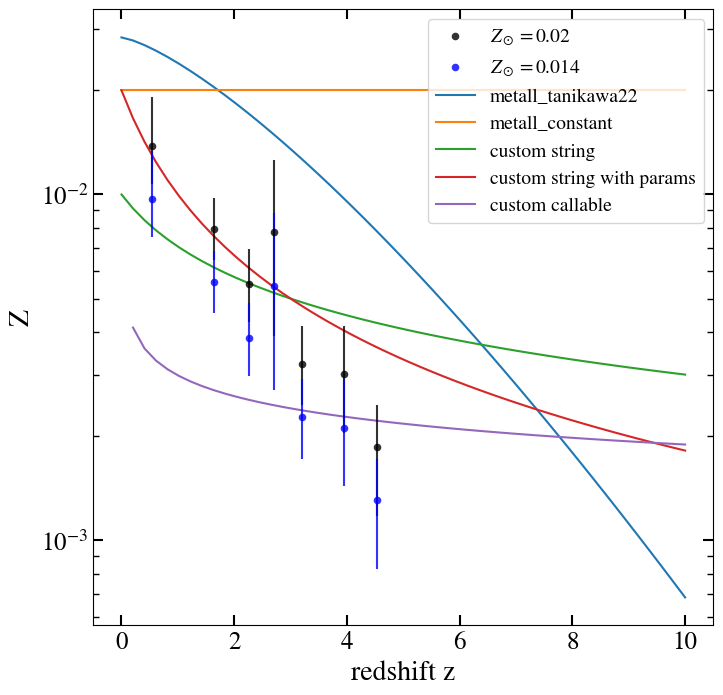

In [9]:
fig_met, ax_met = plt.subplots(figsize=(8, 8))

# We import the metallicity data (it depends on the chosen solar metallicity)
measurements.metallicity(ax=ax_met)
measurements.metallicity(ax=ax_met, z_sun=0.014, color='b')

z_array = np.linspace(0, 10.)

ax_met.plot(
        z_array,
        ebl_model.metall_model(zz_array=z_array, metall_model='metall_tanikawa22'),
        label='metall_tanikawa22')

ax_met.plot(
        z_array,
        ebl_model.metall_model(zz_array=z_array, metall_model='metall_constant'),
        label='metall_constant')

# Write the expression in the dictionary/yaml file with the rest of inputs
ax_met.plot(
    z_array, 
    ebl_model.metall_model(zz_array=z_array, metall_model='0.01*(1 + zz)**-0.5'),
    label='custom string')

# With parameters this time
ax_met.plot(
    z_array, 
    ebl_model.metall_model(zz_array=z_array, metall_model='ci[0]*(1 + zz)**ci[1]',
                           metall_params=[0.02, -1]),
    label='custom string with params')


def metall_funct_custom(zz, params):
    return params[0] * zz**params[1]
    
ax_met.plot(
    z_array, 
    ebl_model.metall_model(zz_array=z_array, metall_model=metall_funct_custom,
                           metall_params=[0.003, -0.2]),
    label='custom callable')

# Figure specifications

plt.yscale('log')

plt.xlabel('redshift z')
plt.ylabel('Z')

ax_met.legend(loc=1, fontsize=14)

## Stellar formation rate - input for stellar EBL contribution
Enter the stellar formation rate ($\rho_\star$) as an input of the model for an SSP.

The code asks for a $\rho_\star$(z) with units M$_{\odot}$ / yr / Mpc$^{3}$.

A custom implementation can be used, given as either a string of text containing the analytical formula or a callable (that can include parameters). We provide examples of these possibilities. The string of text needs the redshift variable to be called $zz$ and the parameters to be a float or an array called $ci$.


| Model name | Formula for $\rho_\star$(z) | Reference parameters | Reference |
| :-: | :-: | :-: | :-: |
| sfr_madau14 | $c_0 \frac{(1 + z) ^ {c_1}}
            {1 + \left((1 + z) / c_2\right) ^ {c_3}}$ |[ 0.015, 2.7, 2.9, 5.6] | [Eq. 15](https://www.annualreviews.org/content/journals/10.1146/annurev-astro-081811-125615#f9) |
| sfr_finke22a | *it has many lines* |  *check the paper* | [Eq. 15](https://iopscience.iop.org/article/10.3847/1538-4357/ac9843) |
| sfr_cuba | $\frac{c_0 + c_1 * (z / c_2) ^ {c_3}}{1. + (z / c_4) ^ {c_5}}$ |  [6.9e-3, 0.14, 2.2, 1.5, 2.7, 4.1] | [Eq. 53](https://iopscience.iop.org/article/10.1088/0004-637X/746/2/125) |
| sfr_constant | $c_0$ | 1. | - |

   -> SFR: default parameters chosen:  [0.015, 2.7, 2.9, 5.6]
   -> SFR: default parameters chosen:  [-2.04, 2.81, 1.25, -1.25, -1.84, -4.4, 1.0, 2.0, 3.0, 4.0]
   -> SFR: default parameters chosen:  [0.0069, 0.14, 2.2, 1.5, 2.7, 4.1]
   -> SFR: default parameters chosen:  [1.0]


/tmp/ipykernel_54883/3228427524.py:44: RuntimeWarning: divide by zero encountered in power
  return params[0] * zz**params[1]


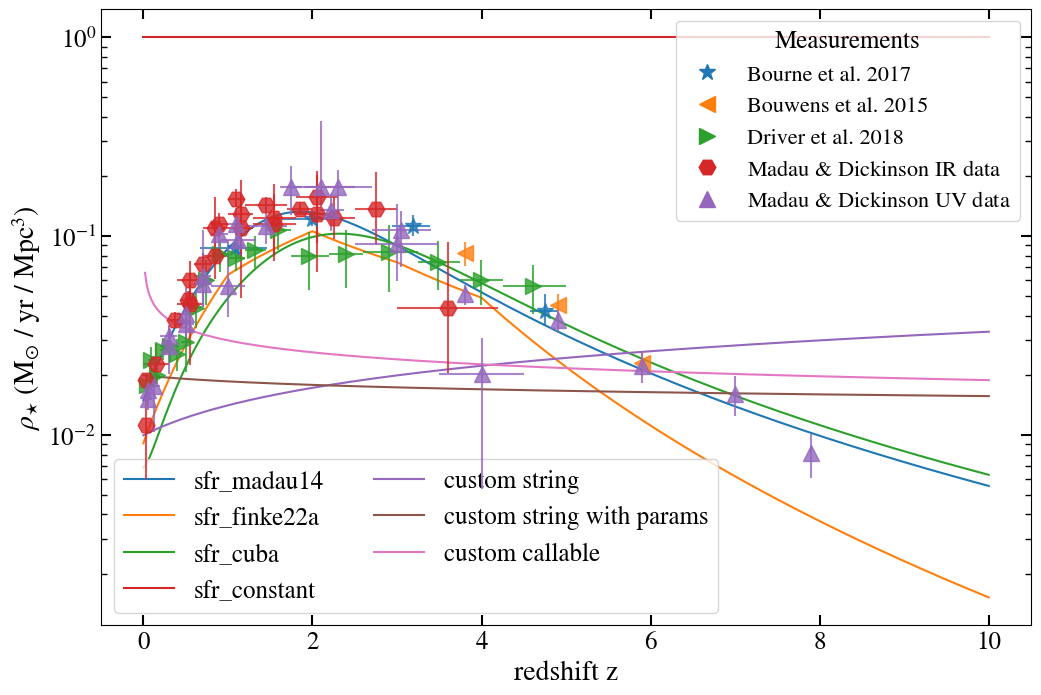

In [10]:
fig_sfr, ax_sfr = plt.subplots(figsize=(12, 8))

z_array = np.linspace(0., 10., num=500)

# We import the metallicity data from the Fermi compilation
measurements.sfr(plot=True, ax=ax_sfr)

ax_sfr.plot(
    z_array, 
    ebl_model.sfr_model(zz_array=z_array, sfr_model='sfr_madau14'),
    label='sfr_madau14')

ax_sfr.plot(
    z_array, 
    ebl_model.sfr_model(zz_array=z_array, sfr_model='sfr_finke22a'),
    label='sfr_finke22a')

ax_sfr.plot(
    z_array, 
    ebl_model.sfr_model(zz_array=z_array, sfr_model='sfr_cuba'),
    label='sfr_cuba')

ax_sfr.plot(
    z_array, 
    ebl_model.sfr_model(zz_array=z_array, sfr_model='sfr_constant'),
    label='sfr_constant')


# Write the expression in the dictionary/yaml file with the rest of inputs
ax_sfr.plot(
    z_array, 
    ebl_model.sfr_model(zz_array=z_array, sfr_model='0.01*(1 + zz)**0.5'),
    label='custom string')

# With parameters this time
ax_sfr.plot(
    z_array, 
    ebl_model.sfr_model(zz_array=z_array, sfr_model='ci[0]*(1 + zz)**ci[1]',
                       sfr_params=[0.02, -0.1]),
    label='custom string with params')


def sfr_funct_custom(zz, params):
    return params[0] * zz**params[1]
    
ax_sfr.plot(
    z_array, 
    ebl_model.sfr_model(zz_array=z_array, sfr_model=sfr_funct_custom,
                       sfr_params=[0.03, -0.2]),
    label='custom callable')


# Figure specifications

plt.yscale('log')

plt.ylabel(r'$\rho_{\star}$ (M$_{\odot}$ / yr / Mpc$^{3}$)')
plt.xlabel('redshift z')

ax_sfr.legend(ncols=2, loc=3)

## Dust reemission templates - input for stellar EBL contribution

This code can use dust reemisison templates to calculate the infrared part of the EBL. This requires external dust reemission templates, that we introduce here. We provide and present two spectral libraries here:
- Chary2001
- BOSA
- We also allow for customization, allowing any spectra as long as they are corectly formatted. We provide a minimal example of how that looks like, inside the directory 'minimal_example/dust_reem_minimal'.

The templates get extrapolated, each of them in different ways.
- Wavelength: none of them get extrapolated at higher or smaller wavelengths.
- Metallicity: Chary2001 spectra do not have a dependency with metallicity, so they remain constant when changing this parameter. BOSA return the values of the limit case closer to metallicities outside the provided range.
- $L_\mathrm{TIR}$: both templates get rescaled to $L_\mathrm{TIR}$ outside the provided range.

Custom templates return the values of the limit case closer to metallicities outside the provided range, and to higher and lower $L_\mathrm{TIR}$ by rescaling them. No extrapolation to wavelengths outside the regions provided.

### Using the dust reemission 
The EBL code initializes an spline that you can also use outside of the code, as:

The inputs needed are different depending on the model.
- BOSA: only needs the model name.
- Chary2001:
    - `f_tir`: normalization factor for the template. It is the number of stars found in a typical galaxy. Given in log10.
    - `wv_reem_min`: minimum wavelength at which reemission happens. This set of templates has luminosities that do not correspond to dust reemisison at small wavelengths, so we need a cut. Input unit is microns.

[0.0004 0.004  0.008  0.02   0.05  ]


(0.0, 24.18648068669528)

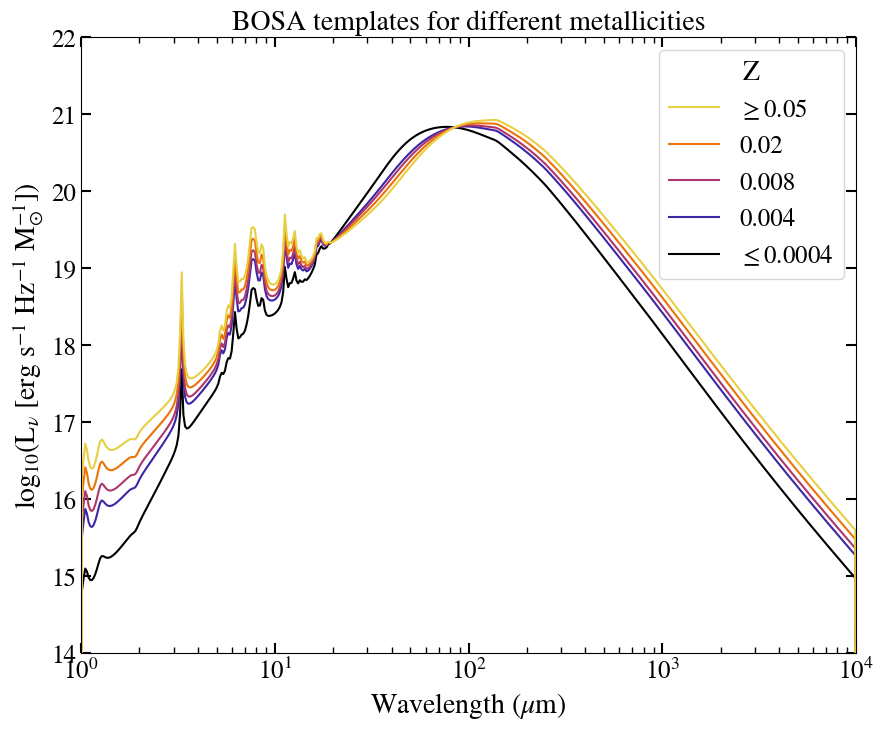

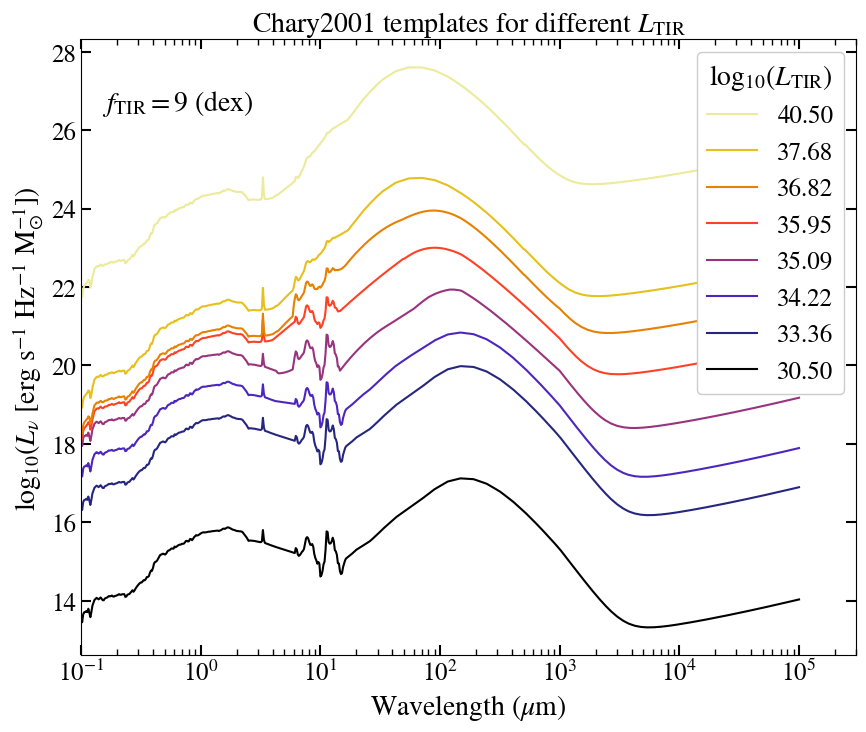

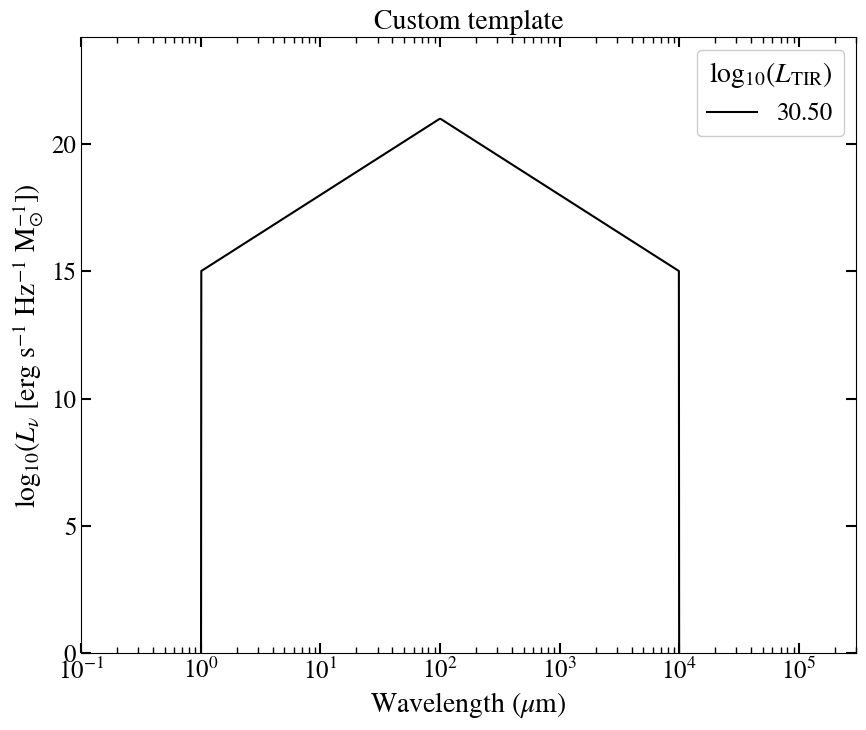

In [11]:
wave_array = np.geomspace(0.1, 1e5, num=700)

# Import the Chary2001 and BOSA spectra

dict_chary = {'library': 'dust_reem_chary2001',
      'f_tir': 9.,  # [dex]
      'wv_reem_min': 0. , # [microns]
         }

dict_bosa = {'library': 'dust_reem_bosa'}

# ---------------------------------------------------------------------
plt.figure(figsize=(10, 8))
plt.title('BOSA templates for different metallicities')

metalls = [6.99103, 7.99103, 8.29205999, 8.69, 9.08794001]
metalls_Ztot = 10**(np.array(metalls) - 12)/4.89778819e-04*0.02
metalls_Ztot_labels = [r'$\leq$'+str(0.0004), 0.004,  0.008,  0.02, r'$\geq$'+str(0.05)]
print(metalls_Ztot)


for iii in range(len(metalls)):
    plt.plot(wave_array,
             ebl_model.dust_reem(
                 wave_array=np.log10(wave_array), 
                 l_tir_array=np.log10(c.L_sun.to(u.erg / u.s).value),
                 metall_array=np.log10(metalls_Ztot[iii]),
                 dust_reem_model=dict_bosa['library']
                 ),
             label=metalls_Ztot_labels[iii],
             c=plt.cm.CMRmap(iii / len(metalls_Ztot)))


handles, labels = plt.gca().get_legend_handles_labels()
order = np.arange(len(handles)-1, -1, -1, dtype=int)
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Z')


plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel(r'log$_{10}$(L$_{\nu}$ '  # /Lsun '
           r'[erg s$^{-1}$ $\mathrm{Hz}^{-1}$ M$_{\odot}^{-1}$])')

plt.xscale('log')
# plt.yscale('log')

plt.xlim(1, 1e4)
plt.ylim(14, 22)

# ---------------------------------------------------------------------

plt.figure(figsize=(10, 8))
plt.title(r'Chary2001 templates for different $L_\mathrm{TIR}$')

plt.plot(wave_array,
         ebl_model.dust_reem(
             wave_array=np.log10(wave_array), 
             l_tir_array=30.5,
             metall_array=np.log10(0.02),
             dust_reem_model=dict_chary['library'],
             dust_reem_params=dict_chary
             ),
         label=r'%.2f' % 30.5, c=plt.cm.CMRmap(0.))

l_tir = np.linspace(33.36, 37.68, num=6)
for ni, i in enumerate(l_tir):
    plt.plot(wave_array,
             ebl_model.dust_reem(
             wave_array=np.log10(wave_array), 
             l_tir_array=i,
             metall_array=np.log10(0.02),
             dust_reem_model=dict_chary['library'],
             dust_reem_params=dict_chary
             ),
             label='%.2f' % i,
             c=plt.cm.CMRmap((ni+1) / (len(l_tir)+2))
             )

plt.plot(wave_array,
         ebl_model.dust_reem(
             wave_array=np.log10(wave_array), 
             l_tir_array=40.5,
             metall_array=np.log10(0.02),
             dust_reem_model=dict_chary['library'],
             dust_reem_params=dict_chary
             ),
         label=r'%.2f' % 40.5, c=plt.cm.CMRmap(0.9))

plt.text(x=0.15, y=26.5, s=r'$f_\mathrm{TIR} = $%.f (dex)' %dict_chary['f_tir'])

plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel(r'log$_{10}(L_{\nu}$ '  # /Lsun '
           r'[erg s$^{-1}$ $\mathrm{Hz}^{-1}$ M$_{\odot}^{-1}$])')

handles, labels = plt.gca().get_legend_handles_labels()
order = np.arange(len(handles)-1, -1, -1, dtype=int)
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           ncol=1, loc=1, title=r'log$_{10}\left(L_\mathrm{TIR}\right)$',
           framealpha=1)

plt.xscale('log')

plt.xlim(0.1, 3e5)
# plt.ylim(16, 25.5)


plt.figure(figsize=(10, 8))
plt.title(r'Custom template')

plt.plot(wave_array,
         ebl_model.dust_reem(
             wave_array=np.log10(wave_array), 
             l_tir_array=30.5,
             metall_array=np.log10(0.02),
             dust_reem_model='notebooks/minimal_example/dust_reem_minimal/',
             ),
         label=r'%.2f' % 30.5, c=plt.cm.CMRmap(0.))


plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel(r'log$_{10}(L_{\nu}$ '  # /Lsun '
           r'[erg s$^{-1}$ $\mathrm{Hz}^{-1}$ M$_{\odot}^{-1}$])')

handles, labels = plt.gca().get_legend_handles_labels()
order = np.arange(len(handles)-1, -1, -1, dtype=int)
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           ncol=1, loc=1, title=r'log$_{10}\left(L_\mathrm{TIR}\right)$',
           framealpha=1)

plt.xscale('log')

plt.xlim(0.1, 3e5)
plt.ylim(bottom=0)

## Dust reemission with black bodies - input for stellar EBL contribution

The second method to calculate the infrared emission consists on sorting dust into different populations, each of them reemiting light with a black body spectral shape.
Different populations of dust emit at different wavelengths. For example, polycyclic aromatic hydrocarbon and very small grains are heated in galaxies to $T \sim \mathcal{O}(100\,\mathrm{K})$, and therefore emit in the mid infrared (MIR).
Moving to higher wavelengths, the dust in the far infrared (FIR) is cold, heated by interstellar radiation fields in galaxies.

We input the temperatures of each dust population and the fraction of absorbed light that goes to each population. This is, you give two arrays such as:

```
dust_reem_params:
    library: black_bodies
    T:
     - 44.
     - 70.
    fracts:
    - 0.
```
The temperature array $T$ lists all the different tempreatures, and the $fracts$ array has the fraction of absorbed light that each population recives. This array is one number shorter than the temperature array, and the last fraction gets calculated by the completion condition $\sum f_i = 1$.


# Intrahalo light and its contribution to the EBL

The IHL is the light caused by stars that have been ejected from their galaxies by dynamical events. These stars would create a faint halo surrounding their host galaxies, but would not have been used to calculate the $\rho_{\star}$. We follow the parametrization described by [Bernal+22](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.107.103046) to calculate the emissivity

$\varepsilon_{\lambda, \mathrm{IHL}} (\lambda, z) = \int ^{M_\mathrm{max}}_{M_\mathrm{min}} dM \, \frac{dn_\mathrm{h}}{dM} \, L_{\lambda, \mathrm{IHL}}(M, z)$

where $dn_\mathrm{h}/dM$ is the halo mass function and $L_{\lambda, \mathrm{IHL}}(M, z)$ is the IHL light specific luminosity emitted by a halo of mass $M$.
We use the same parameters as [Bernal+22](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.107.103046) to characterize $L_{\lambda, \mathrm{IHL}}(M, z)$, taking their definition and freeing the values for the fraction of the total halo luminosity coming from IHL $A\_ihl$ and redshift power-law dependence $alpha$.

We calculate the $dn_\mathrm{h}/dM$ with the $hmf$ [code](https://www.sciencedirect.com/science/article/pii/S221313372100041X?via%3Dihub), a specific tool for calculating halo mass functions.


# ALP DECAY BEING CONSIDERED
Provide the mass and coupling constant of the ALP to photons.
```
axion_params:
  axion_mass:  1      # [eV]
  axion_gamma: 5e-10  # [s**-1]
```